<a href="https://colab.research.google.com/github/stanimman/Fast_ai/blob/master/Dog_Breed_Dataset_with_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b600000 @  0x7feca08ae2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [0]:
!pip -q uninstall Pillow -y

!pip -q install Pillow

In [1]:
import PIL
print(PIL.PILLOW_VERSION)
import sys

5.3.0


In [0]:
# Un-squeeze a dimension
x = torch.Tensor([1, 2, 3])
print(x)
print(x.shape)
r = torch.unsqueeze(x, 0)       # Size: 1x3
print(r)
print(r.shape)
r = torch.unsqueeze(x, 1)   
print(r)
print(r.shape)

tensor([ 1.,  2.,  3.])
torch.Size([3])
tensor([[ 1.,  2.,  3.]])
torch.Size([1, 3])
tensor([[ 1.],
        [ 2.],
        [ 3.]])
torch.Size([3, 1])


In [0]:
input = torch.Tensor(2, 4, 3) # input: 2 x 4 x 3
print(input.unsqueeze(3).size()) # prints - torch.size([1, 2, 4, 3])

torch.Size([2, 4, 3, 1])


In [2]:
!git clone https://github.com/stanimman/Fast_ai.git

Cloning into 'Fast_ai'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [0]:
import sys
sys.path.append('/content/Fast_ai')
from utils import *
from image_classification_from_csv import *
#import Fast_ai/

In [4]:
!pip install -q kaggle-cli
!kg download -u 'stanimman' -p '****' -c 'dog-breed-identification'

/usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py:37: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 37 of the file /usr/local/lib/python3.6/dist-packages/mechanicalsoup/browser.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  response.content, **soup_config)
downloading https://www.kaggle.com/c/dog-breed-identification/download/labels.csv.zip

labels.csv.zip 100% |################################| Time: 0:00:00 738.9 KiB/s

downloading https://www.kaggle.com/c/dog-breed-identification/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |#####################| Time: 0:00:00 591.0 KiB/s

downloading https://www.

In [5]:
!ls

Fast_ai		sample_data		   test.zip
labels.csv.zip	sample_submission.csv.zip  train.zip


In [0]:
!unzip -q labels.csv.zip
!unzip -q train.zip

In [0]:
!unzip -q sample_submission.csv.zip

In [0]:
#%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

In [0]:
!pip install -q pretrainedmodels
import pretrainedmodels
from image_classification_from_csv import *
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)

In [10]:
data_dir = '/content'
label_df = pd.read_csv(join(data_dir, 'labels.csv'))
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
train, valid = train_test_split(label_df, test_size = 0.2, stratify = label_df["breed"])
print(len(train["breed"].unique()))
print(len(valid["breed"].unique()))
train.to_csv("train.csv", index = False)
valid.to_csv("valid.csv", index = False)

120
120


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomRotation(degrees=10, resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'TTA': transforms.Compose([
        transforms.Resize(256),
        transforms.FiveCrop(224),
        transforms.Lambda(lambda crops: 
                          torch.stack([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       (transforms.ToTensor()(crop)) for crop in crops]))
    ])
}

In [13]:
image_datasets = {"train": DatasetFromCsv("train.csv", "train/", data_transforms["train"]),
                  "valid": DatasetFromCsv("valid.csv", "train/", data_transforms["valid"])}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=0)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
dataset_sizes

{'train': 8177, 'valid': 2045}

In [14]:
model_name = 'resnext101_64x4d'
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

# class_element = np.bincount(classes) # Useful to get value count

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/resnext101_64x4d-e77a0586.pth" to /root/.torch/models/resnext101_64x4d-e77a0586.pth
100%|██████████| 334703243/334703243 [00:13<00:00, 25188418.33it/s]


In [0]:
num_classes = len(label_df["breed"].unique())
for param in model.parameters():
    param.requires_grad = False
    
model.last_linear = nn.Linear(model.last_linear.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.003)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
lr_find = lr_finder(model, criterion, optimizer, dataloaders, device)

In [17]:
lr_find.fit()

[==============================                    ] 60%

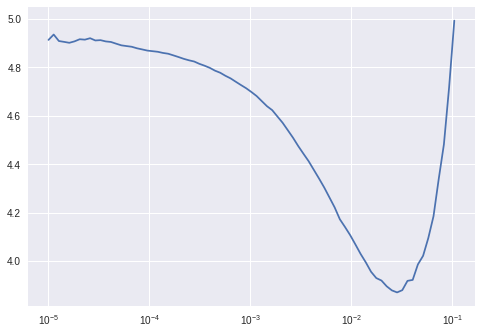

In [18]:
lr_find.plot_lr()

In [0]:
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')

for param in model.parameters():
    param.requires_grad = False
    
model.last_linear = nn.Linear(model.last_linear.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-2)

In [20]:
model, _ = train_model(model, criterion, optimizer, dataloaders, 
                       device, dataset_sizes, num_classes, num_epochs = 5)

Epoch 1/5
----------
train[==================================================] 100%
train Loss: 3.23883673872708 Acc: 0.5887244710774123
valid[====================] 100%
valid Loss: 1.284283773240367 Acc: 0.7691931540342297

Epoch 2/5
----------
train[==================================================] 100%
train Loss: 1.3972854832645383 Acc: 0.7631160572337043
valid[====================] 100%
valid Loss: 1.481438087076313 Acc: 0.7755501222493887

Epoch 3/5
----------
train[==================================================] 100%
train Loss: 1.322532624797161 Acc: 0.7940564999388529
valid[====================] 100%
valid Loss: 1.5176865191797755 Acc: 0.7970660146699265

Epoch 4/5
----------
train[==================================================] 100%
train Loss: 1.3147596259476926 Acc: 0.8127675186498716
valid[====================] 100%
valid Loss: 1.386635959527312 Acc: 0.8312958435207823

Epoch 5/5
----------
train[==================================================] 100%
train Loss

In [0]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = SGDR(optimizer = optimizer, T_max = 128)

In [22]:
model, _ = train_model(model, criterion, optimizer, dataloaders, 
                       device, dataset_sizes, num_classes, scheduler, 
                       num_epochs = 5)

Epoch 1/5
----------
train[==================================================] 100%
train Loss: 0.4836379512242442 Acc: 0.9081570258040846
valid[====================] 100%
valid Loss: 0.6782096292103998 Acc: 0.8865525672371637

Epoch 2/5
----------
train[==================================================] 100%
train Loss: 0.3734896697201472 Acc: 0.9245444539562186
valid[====================] 100%
valid Loss: 0.6784216512094792 Acc: 0.8909535452322738

Epoch 3/5
----------
train[==================================================] 100%
train Loss: 0.3588024158578813 Acc: 0.9254005136358078
valid[====================] 100%
valid Loss: 0.6704131338007584 Acc: 0.8924205378973105

Epoch 4/5
----------
train[==================================================] 100%
train Loss: 0.36950153908039113 Acc: 0.922220863397334
valid[====================] 100%
valid Loss: 0.6521151457264255 Acc: 0.8904645476772616

Epoch 5/5
----------
train[==================================================] 100%
trai

In [0]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = SGDR(optimizer = optimizer, T_max = 128, cycle_mult = 2)

In [25]:
model, _ = train_model(model, criterion, optimizer, dataloaders, 
                       device, dataset_sizes, num_classes, scheduler, 
                       num_epochs = 7)

Epoch 1/7
----------
train[==================================================] 100%
train Loss: 0.3561241630857959 Acc: 0.9235661000366883
valid[====================] 100%
valid Loss: 0.6613954946872366 Acc: 0.891442542787286

Epoch 2/7
----------
train[==================================================] 100%
train Loss: 0.3657299672094318 Acc: 0.9247890424361013
valid[====================] 100%
valid Loss: 0.6505411615290094 Acc: 0.8933985330073348

Epoch 3/7
----------
train[==================================================] 100%
train Loss: 0.28127152054966176 Acc: 0.9382414088296441
valid[====================] 100%
valid Loss: 0.629728045811863 Acc: 0.8929095354523227

Epoch 4/7
----------
train[==================================================] 100%
train Loss: 0.3457481951939239 Acc: 0.9263788675553382
valid[====================] 100%
valid Loss: 0.7015529119990275 Acc: 0.8860635696821515

Epoch 5/7
----------
train[==================================================] 100%
train

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomRotation(degrees=10, resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'TTA': transforms.Compose([
        transforms.Resize(299),
        transforms.FiveCrop(256),
        transforms.Lambda(lambda crops: 
                          torch.stack([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       (transforms.ToTensor()(crop)) for crop in crops]))
    ])
}

In [0]:
model.avg_pool = nn.AdaptiveAvgPool2d(1)

image_datasets = {"train": DatasetFromCsv("train.csv", "train/", data_transforms["train"]),
                  "valid": DatasetFromCsv("valid.csv", "train/", data_transforms["valid"])}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=0)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = SGDR(optimizer = optimizer, T_max = 128, cycle_mult = 2)

In [31]:
model, _ = train_model(model, criterion, optimizer, dataloaders, 
                       device, dataset_sizes, num_classes, scheduler, 
                       num_epochs = 7)

Epoch 1/7
----------
train[==================================================] 100%
train Loss: 0.2548175657693544 Acc: 0.9367738779503486
valid[====================] 100%
valid Loss: 0.5298706752746787 Acc: 0.9061124694376528

Epoch 2/7
----------
train[==================================================] 100%
train Loss: 0.2634875771978074 Acc: 0.9400758224287636
valid[====================] 100%
valid Loss: 0.53506085282433 Acc: 0.9051344743276283

Epoch 3/7
----------
train[==================================================] 100%
train Loss: 0.18062719850511297 Acc: 0.9515714809832457
valid[====================] 100%
valid Loss: 0.5186945190348077 Acc: 0.9075794621026894

Epoch 4/7
----------
train[==================================================] 100%
train Loss: 0.2421385951288262 Acc: 0.9420325302678244
valid[====================] 100%
valid Loss: 0.5792948350419626 Acc: 0.8943765281173593

Epoch 5/7
----------
train[==================================================] 100%
train

In [0]:
torch.save(model.state_dict(), "299_lastlayer.pt")

In [0]:
# Not Sure why I need it
# model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
# model.last_linear = nn.Linear(model.last_linear.in_features, num_classes)
# model.load_state_dict(torch.load('299_lastlayer.pt'))
# for param in model.parameters():
#     param.requires_grad = False
# model.avg_pool = nn.AdaptiveAvgPool2d(1)

In [34]:
path = 'train/'
file_path = 'valid.csv'
tfm2 = data_transforms["valid"]
predictions = predict_fn(model, path, device, num_classes, transform = tfm2, 
                         file_path = file_path, TTA = False, mode = "valid", 
                         batch_size = 64, suffix = ".jpg")

[==================================================] 100%
Time taken for prediction 2.0m 9.730500221252441s


In [35]:
probs = predictions["log_pred"]
preds = np.argmax(predictions["log_pred"], axis=1)
val_y = np.array(predictions["val_y"])
img_names = predictions["img_names"]
classes = predictions["classes"]
print(accuracy_score(val_y, preds))

0.9075794621026895


#Validate using TTA

In [36]:
probs = predictions["log_pred"]
preds = np.argmax(predictions["log_pred"], axis=1)
val_y = np.array(predictions["val_y"])
img_names = predictions["img_names"]
classes = predictions["classes"]
print(accuracy_score(val_y, preds))

0.9075794621026895
